In [1]:
library(Seurat)
library(ArchR)
library(cowplot)
library(tidyverse)

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [2]:
ARROWFILE <- "../data/10k_sorted.arrow"
SEURATOBJ <- "../data/sorted_10k_seurat.rds"

In [3]:
gsm_se    <- getMatrixFromArrow(ARROWFILE, 'GeneScoreMatrix')
gsm       <- assays(gsm_se)[['GeneScoreMatrix']]
row_data  <- rowData(gsm_se)
genes     <- row_data["name"]
gsm_df    <- as.data.frame(as.matrix(gsm))
gsm_df    <- sapply(gsm_df + 0.5, as.integer) # round to nearest integer.
row.names(gsm_df) <- genes$name
colnames(gsm_df)  <- substring(colnames(gsm_df), 11, 30)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromArrow-7d3b61f05f-Date-2020-11-30_Time-20-00-54.log
If there is an issue, please report to github with logFile!

2020-11-30 20:00:54 : Getting GeneScoreMatrix from ArrowFile : 10k_sorted.arrow, 0.007 mins elapsed.

2020-11-30 20:01:27 : Organizing SE GeneScoreMatrix from ArrowFile : 10k_sorted.arrow, 0.555 mins elapsed.



In [4]:
head(gsm_df)

,#TGAGCAAAGGCCTGGT-1,#AACCGCTCATATAACC-1,#GGAGTCTGTGAGCAAG-1,#TAGCTAGGTTTGGGTA-1,#TTGGAGGCAGGCTTCG-1,#GTTAAGTGTCACTCGC-1,#AATCGCCCAACCCTCC-1,#GGTTGCATCCTGGCTT-1,#CATAGACTCCCTGGAA-1,#GGTTGCGGTAAACAAG-1,⋯,#TTAACTGAGCGTGCAC-1,#AAGACATAGAACCTGT-1,#GGTTTGTAGCTCATAA-1,#AGAGGATGTAACGTGC-1,#CCGTTGCGTACGATTG-1,#TTACCGTGTTCAAGCA-1,#ATTACGTCATTATGAC-1,#CTTGAACAGCGGGCAA-1,#TAACCTAAGTAAAGGT-1,#CAAGTATGTCTTTATG-1
OR4F5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC729737,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC101928626,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FAM87B,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LINC01128,0,0,0,0,0,0,0,0,0,0,⋯,6,0,0,0,0,0,0,0,0,0
LINC00115,0,1,0,0,0,0,0,0,0,0,⋯,5,0,0,0,0,0,0,0,0,0


In [5]:
predictedSeurat <- CreateSeuratObject(
  gsm_df,
  project = "PredictedGeneExpresion",
  assay = "RNA",
  min.cells = 0,
  min.features = 0,
  names.field = 1,
  names.delim = "-",
  meta.data = NULL
)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [6]:
expressionSeurat <- readRDS(file = SEURATOBJ)

In [7]:
anchors <- FindIntegrationAnchors(object.list = c(predictedSeurat, expressionSeurat), dims = 1:20)

Loading required package: Signac

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23245 anchors

Filtering anchors

	Retained 5390 anchors



In [8]:
combinedSeurat <- IntegrateData(anchorset = anchors, dims = 1:20)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"


In [10]:
DefaultAssay(combinedSeurat) <- "integrated"

# Run the standard workflow for visualization and clustering
combinedSeurat <- ScaleData(combinedSeurat, verbose = FALSE)
combinedSeurat <- RunPCA(combinedSeurat, npcs = 30, verbose = FALSE)
# t-SNE and Clustering
combinedSeurat <- RunUMAP(combinedSeurat, reduction = "pca", dims = 1:20)
combinedSeurat <- FindNeighbors(combinedSeurat, reduction = "pca", dims = 1:20)
combinedSeurat <- FindClusters(combinedSeurat, resolution = 0.5)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
20:10:09 UMAP embedding parameters a = 0.9922 b = 1.112

20:10:09 Read 23493 rows and found 20 numeric columns

20:10:09 Using Annoy for neighbor search, n_neighbors = 30

20:10:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

20:10:13 Writing NN index file to temp file /tmp/RtmpFwDuxF/file7d52a65361

20:10:13 Searching Annoy index using 1 thread, search_k = 3000

20:10:21 Annoy recall = 100%

20:10:22 Commencing smooth kNN distance calibration using 1 thread

20:10:24 Initializing fro

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 23493
Number of edges: 925143

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9190
Number of communities: 18
Elapsed time: 6 seconds


In [11]:
combinedSeurat

An object of class Seurat 
253137 features across 23493 samples within 5 assays 
Active assay: integrated (2000 features, 2000 variable features)
 4 other assays present: RNA, ATAC, ATAC_distal, ATAC_promoter
 2 dimensional reductions calculated: pca, umap

In [12]:
# options(repr.plot.width = 14, repr.plot.height = 7)
# # Visualization
# p1 <- DimPlot(combinedSeurat, reduction = "umap", group.by = "assay")
# p2 <- DimPlot(combinedSeurat, reduction = "umap", label = TRUE)
# plot_grid(p1, p2)


ERROR: Error: Cannot find 'assay' in this Seurat object


In [13]:
umap_tx = combinedSeurat@reductions$umap@cell.embeddings  %>% as.data.frame() %>% cbind(tx = combinedSeurat@meta.data$orig.ident)


In [14]:
umap_tx

,UMAP_1,UMAP_2,tx
,<dbl>,<dbl>,<chr>
#TGAGCAAAGGCCTGGT-1,6.354074,-3.406333,PredictedGeneExpresion
#AACCGCTCATATAACC-1,6.605480,-3.738700,PredictedGeneExpresion
#GGAGTCTGTGAGCAAG-1,5.891947,-3.823376,PredictedGeneExpresion
#TAGCTAGGTTTGGGTA-1,6.377788,-3.559437,PredictedGeneExpresion
#TTGGAGGCAGGCTTCG-1,5.827798,2.055705,PredictedGeneExpresion
#GTTAAGTGTCACTCGC-1,6.508309,-4.244980,PredictedGeneExpresion
#AATCGCCCAACCCTCC-1,6.417743,-3.447002,PredictedGeneExpresion
#GGTTGCATCCTGGCTT-1,6.482069,-3.885705,PredictedGeneExpresion
#CATAGACTCCCTGGAA-1,6.564779,-3.460937,PredictedGeneExpresion


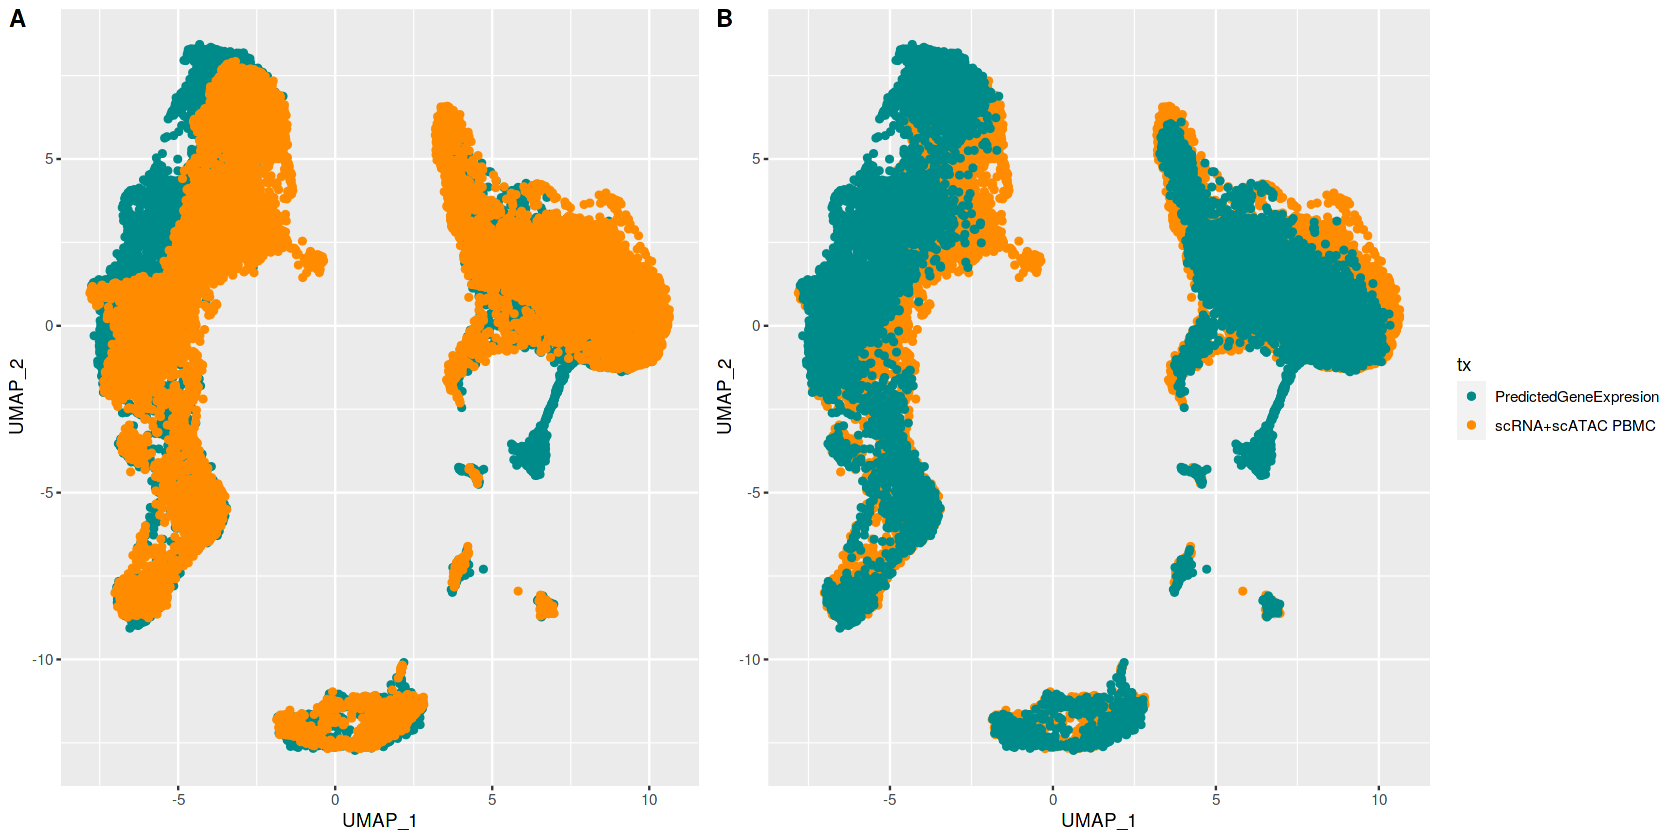

In [40]:
a <- ggplot() + 
    geom_point(data = umap_tx[umap_tx$tx == "PredictedGeneExpresion",], aes(x=UMAP_1, y=UMAP_2, color=tx), show.legend = FALSE) + 
    geom_point(data = umap_tx[umap_tx$tx == "scRNA+scATAC PBMC",], aes(x=UMAP_1, y=UMAP_2, color=tx), show.legend = FALSE) + 
    scale_color_manual(values=c("PredictedGeneExpresion" = "darkcyan", 
                                "scRNA+scATAC PBMC" = "darkorange"))

b <- ggplot() +
    geom_point(data = umap_tx[umap_tx$tx == "scRNA+scATAC PBMC",], aes(x=UMAP_1, y=UMAP_2, color=tx)) + 
    geom_point(data = umap_tx[umap_tx$tx == "PredictedGeneExpresion",], aes(x=UMAP_1, y=UMAP_2, color=tx)) +
    scale_color_manual(values=c("PredictedGeneExpresion" = "darkcyan", 
                                "scRNA+scATAC PBMC" = "darkorange"))

plot_grid(a, b, labels = c("A", "B"), rel_widths = c(8, 11))